In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
%matplotlib inline


df = pd.read_csv("defaults.csv", header = 1, index_col = 'ID')
df.columns = [x.lower() for x in list(df.columns)]
df.columns = ['credit_amount', 'sex', 'education', 'marital_status', 'age', 'pay_sept', 
              'pay_aug','pay_jul', 'pay_jun', 'pay_may', 'pay_apr', 'bill_amt_sept', 
              'bill_amt_aug','bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 
              'pay_amt_sept','pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 
              'pay_amt_apr','default']

for column in ['credit_amount', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']:
    df[column] = df[column]/1000
    
gender_remapping = {1: 'male', 2: 'female'}
df.sex = df.sex.map(gender_remapping)

df.education = df.education.astype(str)
education_remapping = {'1': 'grad_school', '2': 'bachelors', '3': 'high_school', '4': 'other', 
                       '5': 'other', '6': 'other', '0': 'other'}
df.education = df.education.map(education_remapping)

df.marital_status = df.marital_status.astype(str)
marital_status_remapping = {'1': 'married', '2': 'single', '3': 'divorced', '0': 'other'}
df.marital_status = df.marital_status.map(marital_status_remapping)

# Original dataset

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
credit_amount     30000 non-null float64
sex               30000 non-null object
education         30000 non-null object
marital_status    30000 non-null object
age               30000 non-null int64
pay_sept          30000 non-null int64
pay_aug           30000 non-null int64
pay_jul           30000 non-null int64
pay_jun           30000 non-null int64
pay_may           30000 non-null int64
pay_apr           30000 non-null int64
bill_amt_sept     30000 non-null float64
bill_amt_aug      30000 non-null float64
bill_amt_jul      30000 non-null float64
bill_amt_jun      30000 non-null float64
bill_amt_may      30000 non-null float64
bill_amt_apr      30000 non-null float64
pay_amt_sept      30000 non-null float64
pay_amt_aug       30000 non-null float64
pay_amt_jul       30000 non-null float64
pay_amt_jun       30000 non-null float64
pay_amt_may       30000 non-null float64
pay_am

In [3]:
df.columns

Index(['credit_amount', 'sex', 'education', 'marital_status', 'age',
       'pay_sept', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr',
       'bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept', 'pay_amt_aug',
       'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr', 'default'],
      dtype='object')

# Feature engineering.

** Credit utilization columns for each month. **

In [4]:
for column in ['bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 
               'bill_amt_jun','bill_amt_may', 'bill_amt_apr']:
    df['credit_util_' + column.split('_')[2]] = df.loc[:, column] / df.loc[:, 'credit_amount']

In [5]:
df.loc[:5, ['credit_amount', 'bill_amt_sept', 'credit_util_sept']]

credit_amount  bill_amt_sept  credit_util_sept
ID                                                
1            20.0          3.913          0.195650
2           120.0          2.682          0.022350
3            90.0         29.239          0.324878
4            50.0         46.990          0.939800
5            50.0          8.617          0.172340

** Cashflow for each month. **

In [6]:
bills = ['bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 
         'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr']
payms = ['pay_amt_sept', 'pay_amt_aug', 'pay_amt_jul', 
         'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']

for bill, paym in zip(bills, payms):
    df['cash_flow_' + bill.split('_')[2]] = df.loc[:, paym] - df.loc[:, bill] 

In [7]:
df.head()

credit_amount     sex  education marital_status  age  pay_sept  pay_aug  \
ID                                                                            
1            20.0  female  bachelors        married   24         2        2   
2           120.0  female  bachelors         single   26        -1        2   
3            90.0  female  bachelors         single   34         0        0   
4            50.0  female  bachelors        married   37         0        0   
5            50.0    male  bachelors        married   57        -1        0   

    pay_jul  pay_jun  pay_may      ...        credit_util_jul  \
ID                                 ...                          
1        -1       -1       -2      ...               0.034450   
2         0        0        0      ...               0.022350   
3         0        0        0      ...               0.150656   
4         0        0        0      ...               0.985820   
5        -1        0        0      ...               0.716700   

    credit_util_jun  credit_util_may  credit_util_apr  cash_flow_sept  \
ID                                                                      
1          0.000000         0.000000         0.000000          -3.913   
2          0.027267         0.028792         0.027175          -2.682   
3          0.159233         0.166089         0.172767         -27.721   
4          0.566280         0.579180         0.590940         -44.990   
5          0.418800         0.382920         0.382620          -6.617   

    cash_flow_aug  cash_flow_jul  cash_flow_jun  cash_flow_may  cash_flow_apr  
ID                                                                             
1          -2.413         -0.689          0.000          0.000          0.000  
2          -0.725         -1.682         -2.272         -3.455         -1.261  
3         -12.527        -12.559        -13.331        -13.948        -10.549  
4         -46.214        -48.091        -27.214        -27.890        -28.547  
5          31.011        -25.835        -11.940        -18.457        -18.452  

[5 rows x 36 columns]

# Train - test split.

In [8]:
X_columns = df.drop(['default'], axis = 1).columns
X = df.drop(['default'], axis = 1).values
y = df[['default']].values.ravel()

In [9]:
from collections import Counter
print(sorted(Counter(y).items()))

[(0, 23364), (1, 6636)]


In [10]:
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, stratify = y, test_size=0.3, random_state=1)

In [11]:
print(sorted(Counter(y_train).items()))

[(0, 16355), (1, 4645)]


In [12]:
print(sorted(Counter(y_test).items()))

[(0, 7009), (1, 1991)]


In [13]:
X_train = pd.DataFrame(X_train, columns = X_columns)
X_test = pd.DataFrame(X_test, columns = X_columns)

In [14]:
X_train['credit_amount'] = \
    X_train['credit_amount'].astype('float64')
X_train.loc[:, 'age':'pay_apr'] = \
    X_train.loc[:, 'age':'pay_apr'].astype('int64')
X_train.loc[:, 'bill_amt_sept':'pay_amt_apr'] = \
    X_train.loc[:, 'bill_amt_sept':'pay_amt_apr'].astype('float64')
X_train.loc[:, 'credit_util_sept':'cash_flow_apr'] = \
    X_train.loc[:, 'credit_util_sept':'cash_flow_apr'].astype('float64')

X_test['credit_amount'] = \
    X_test['credit_amount'].astype('float64')
X_test.loc[:, 'age':'pay_apr'] = \
    X_test.loc[:, 'age':'pay_apr'].astype('int64')
X_test.loc[:, 'bill_amt_sept':'pay_amt_apr'] = \
    X_test.loc[:, 'bill_amt_sept':'pay_amt_apr'].astype('float64')
X_test.loc[:, 'credit_util_sept':'cash_flow_apr'] = \
    X_test.loc[:, 'credit_util_sept':'cash_flow_apr'].astype('float64')

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 35 columns):
credit_amount       21000 non-null float64
sex                 21000 non-null object
education           21000 non-null object
marital_status      21000 non-null object
age                 21000 non-null int64
pay_sept            21000 non-null int64
pay_aug             21000 non-null int64
pay_jul             21000 non-null int64
pay_jun             21000 non-null int64
pay_may             21000 non-null int64
pay_apr             21000 non-null int64
bill_amt_sept       21000 non-null float64
bill_amt_aug        21000 non-null float64
bill_amt_jul        21000 non-null float64
bill_amt_jun        21000 non-null float64
bill_amt_may        21000 non-null float64
bill_amt_apr        21000 non-null float64
pay_amt_sept        21000 non-null float64
pay_amt_aug         21000 non-null float64
pay_amt_jul         21000 non-null float64
pay_amt_jun         21000 non-null float64
pay_a

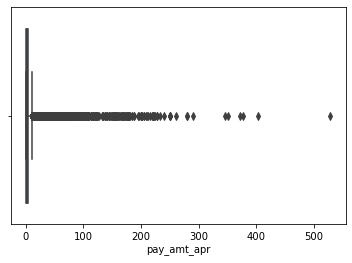

In [16]:
_ = sns.boxplot(X_train['pay_amt_apr'])  
plt.show()

In [17]:
float_columns = X_train.select_dtypes(include=['float64']).columns
int_columns=X_train.select_dtypes(include=['int64']).columns

numeric_columns=float_columns.union(int_columns)

categorical_columns = X_train.select_dtypes(include=['object']).columns

In [18]:
categorical_columns

Index(['sex', 'education', 'marital_status'], dtype='object')

In [19]:
numeric_columns

Index(['age', 'bill_amt_apr', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_sept', 'cash_flow_apr', 'cash_flow_aug',
       'cash_flow_jul', 'cash_flow_jun', 'cash_flow_may', 'cash_flow_sept',
       'credit_amount', 'credit_util_apr', 'credit_util_aug',
       'credit_util_jul', 'credit_util_jun', 'credit_util_may',
       'credit_util_sept', 'pay_amt_apr', 'pay_amt_aug', 'pay_amt_jul',
       'pay_amt_jun', 'pay_amt_may', 'pay_amt_sept', 'pay_apr', 'pay_aug',
       'pay_jul', 'pay_jun', 'pay_may', 'pay_sept'],
      dtype='object')

# Replacing outliers, imputing missing numerical and categorical values.

In [20]:
def outlier_replace(data,train,column):
    quartile_1, quartile_3 = np.percentile(train[column], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (float(iqr) * 1.5)
    upper_bound = quartile_3 + (float(iqr) * 1.5)
    data.loc[(data[column]<lower_bound) | (data[column] > upper_bound),[column]] = train[column].median()
    return data[column]

In [21]:
def imputation_missing_numerical(data,train,column):
    data[column] = data[column].fillna(train[column].median())
    return data[column]

In [22]:
def imputation_missing_categorical(data,column):
    data[column] = data[column].fillna('other')
    return data[column]   

In [23]:
for numeric in numeric_columns:
    X_train[numeric] = outlier_replace(X_train,X_train,numeric)
    #X_train[numeric] = imputation_missing_numerical(train_x,train_x,numeric)
    
    X_test[numeric] = outlier_replace(X_test,X_train,numeric)
    #X_test[numeric] = imputation_missing_numerical(X_test,X_train,numeric)   
    
#for categorical in categorical_columns:
#    X_train[categorical] = imputation_missing_categorical(X_train,categorical)
#    X_test[categorical] = imputation_missing_categorical(X_test,categorical)   

In [24]:
def dummies(data,col):
    y = pd.get_dummies(data[col],prefix=col)
    data.drop([col],axis=1,inplace=True)
    return y   

In [25]:
X_train_dummies  = pd.concat([dummies(X_train,col) for col in categorical_columns], 
                             axis=1)
X_test_dummies  = pd.concat([dummies(X_test,col) for col in categorical_columns], 
                            axis=1) 

In [26]:
# Get missing columns in the training vs test set
missing_cols = set(X_train_dummies.columns) - set(X_test_dummies.columns )
print(missing_cols)

# Add a missing column in the test set with default values equal to 0
for col in missing_cols:
    X_test_dummies[col] = 0

X_test_dummies=X_test_dummies[X_train_dummies.columns]

set()


In [27]:
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [28]:
X_train = pd.concat([X_train[numeric_columns],X_train_dummies],axis=1)
X_test = pd.concat([X_test[numeric_columns],X_test_dummies],axis=1)

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 42 columns):
age                        21000 non-null float64
bill_amt_apr               21000 non-null float64
bill_amt_aug               21000 non-null float64
bill_amt_jul               21000 non-null float64
bill_amt_jun               21000 non-null float64
bill_amt_may               21000 non-null float64
bill_amt_sept              21000 non-null float64
cash_flow_apr              21000 non-null float64
cash_flow_aug              21000 non-null float64
cash_flow_jul              21000 non-null float64
cash_flow_jun              21000 non-null float64
cash_flow_may              21000 non-null float64
cash_flow_sept             21000 non-null float64
credit_amount              21000 non-null float64
credit_util_apr            21000 non-null float64
credit_util_aug            21000 non-null float64
credit_util_jul            21000 non-null float64
credit_util_jun            21000 non-null

In [30]:
X_train.shape, X_test.shape

((21000, 42), (9000, 42))

# Learning curve and corresponding plotting function.

** AUC scorer function. **

In [31]:
from sklearn.metrics import make_scorer

scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba = True)

In [1]:
def learning_curve_output(X_train, y_train, clf):
    ''' This function outputs the model performance 
    for different sizes of training dataset.'''
    
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf, 
                    X=X_train, 
                    y=y_train,
                    train_sizes=np.linspace(0.1, 1.0, 5),
                    cv=5,
                    scoring = scorer,
                    n_jobs=-1,
                    shuffle=True)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    return train_sizes, train_mean, train_std, test_mean, test_std

In [2]:
def learning_curve_plt(train_sizes, train_mean, train_std, test_mean, test_std, clf_name):
    '''This function plots a learning curve for different classifiers.'''
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(train_sizes, train_mean, 
                 color='blue', marker='o', 
                 markersize=5, label='training AUC')

    _ = plt.fill_between(train_sizes, 
                         train_mean + train_std,
                         train_mean - train_std, 
                         alpha=0.15, color='blue')

    _ = plt.plot(train_sizes, test_mean, 
                 color='green', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation AUC')

    _ = plt.fill_between(train_sizes, 
                         test_mean + test_std,
                         test_mean - test_std, 
                         alpha=0.15, color='green')

    _ = plt.title('Learning curve for ' + str(clf_name))
    _ = plt.xlabel('Number of training samples', fontsize=14)
    _ = plt.ylabel('AUC score', fontsize=14)
    _ = plt.legend(loc='lower right', fontsize=14)
    _ = plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    _ = plt.tight_layout()
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

# Validation curve and corresponding plotting function.

In [34]:
def validation_curve_output(X_train, y_train, clf, param_range, param_name):
    '''This function outputs the model performance as a funtion of a certain 
    model parameter with the other parameters fixed: validation curve.'''
    
    train_scores, test_scores = validation_curve(
                    estimator=clf, 
                    X=X_train, 
                    y=y_train, 
                    param_name=param_name, 
                    param_range=param_range,
                    cv=5,
                    scoring = scorer,
                    n_jobs = -1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    return train_mean, train_std, test_mean, test_std

In [35]:
def validation_curve_plt(train_mean, train_std, test_mean, test_std, param_range, param_name, clf_name):
    '''This function plots the validation curve for different models'''
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(param_range, train_mean, 
                 color='blue', marker='o', 
                 markersize=5, label='training AUC')

    _ = plt.fill_between(param_range, train_mean + train_std,
                         train_mean - train_std, alpha=0.15,
                         color='blue')

    _ = plt.plot(param_range, test_mean, 
                 color='green', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation AUC')

    _ = plt.fill_between(param_range, 
                         test_mean + test_std,
                         test_mean - test_std, 
                         alpha=0.15, color='green')

    _ = plt.xscale('log')
    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlabel('Parameter ' + str(param_name), fontsize = 14)
    _ = plt.ylabel('AUC score', fontsize = 14)
    _ = plt.title('Validation curve for ' + str(clf_name) + ':' + 
                  str(param_name), fontsize = 14)
    _ = plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    _ = plt.tight_layout()
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

# ROC curve plotting function

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def ROC_plt(y_pred_train, y_pred_test, classifier):
    '''This function plots ROC curve for a given model.'''

    fpr_train, tpr_train, thresholds_train = roc_curve(y_true=y_train, y_score=y_pred_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_true=y_test, y_score=y_pred_test)

    roc_auc_train = auc(x=fpr_train, y=tpr_train)
    roc_auc_test = auc(x=fpr_test, y=tpr_test)

    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(fpr_train, tpr_train, color='black', linestyle='-', 
                 label='%s (auc = %0.3f)' % (classifier + ' train', roc_auc_train))
    _ = plt.plot(fpr_test, tpr_test, color='red', linestyle='-', 
                 label='%s (auc = %0.3f)' % (classifier + ' test', roc_auc_test))
    _ = plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlim([0., 1.])
    _ = plt.ylim([0., 1.])
    _ = plt.xlabel('False Positive Rate', fontsize = 14)
    _ = plt.ylabel('True Positive Rate', fontsize = 14)
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    _ = plt.tight_layout()
    _ = plt.title('ROC curve', fontsize = 14)
    
    return plt.show()

# Precision - recall plotting function.

In [37]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def precision_recall_curve_plt(y_pred_train, y_pred_test, classifier):
    '''This function plots precision-recall curve for a given model.'''

    average_precision = average_precision_score(y_true = y_test, y_score = y_pred_test)

    precision_train, recall_train, thresholds_train = precision_recall_curve(y_true=y_train, 
                                                                             probas_pred=y_pred_train)
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_true=y_test, 
                                                                          probas_pred=y_pred_test)

    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(recall_train, precision_train, color='black', linestyle='-', 
                 label='%s' % (classifier + ' train'))
    _ = plt.plot(recall_test, precision_test, color='red', linestyle='-', 
                 label='%s' % (classifier + ' test'))
    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlim([0., 1.])
    _ = plt.ylim([0., 1.])
    _ = plt.xlabel('Recall', fontsize = 14)
    _ = plt.ylabel('Precision', fontsize = 14)
    _ = plt.tight_layout()
    _ = plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision), fontsize = 14)
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

# Logistic regression

In [38]:
clf = LogisticRegression(solver = 'lbfgs', 
                         penalty = 'l2', 
                         n_jobs = -1, 
                         max_iter = 500, 
                         class_weight = 'balanced')

# Fit the model on the trainng data.
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print('Training accuracy (default logistic regression):', 
      accuracy_score(y_true = y_train, 
                     y_pred = y_pred_train))
print('Test accuracy (default logistic regression):', 
      accuracy_score(y_true = y_test, 
                     y_pred = y_pred_test))

print('AUC score for the training data (default logistic regression):', 
      roc_auc_score(y_true = y_train, 
                    y_score = clf.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default logistic regression):', 
      roc_auc_score(y_true = y_test, 
                    y_score = clf.predict_proba(X_test)[:,1]))

Training accuracy (default logistic regression): 0.625095238095
Test accuracy (default logistic regression): 0.581444444444
AUC score for the training data (default logistic regression): 0.683526419831
AUC score for the test data (default logistic regression): 0.676945455577


# Validation curves (logistic regression)

In [100]:
C_lr = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_mean_lr_C, train_std_lr_C, test_mean_lr_C, test_std_lr_C = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            clf, 
                            C_lr, 
                            'C')

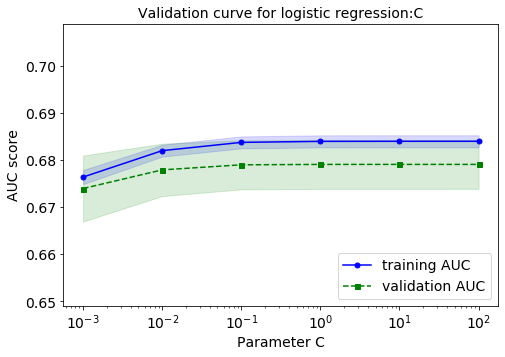

In [101]:
validation_curve_plt(train_mean_lr_C, 
                     train_std_lr_C, 
                     test_mean_lr_C, 
                     test_std_lr_C, 
                     C_lr, 
                     'C', 
                     'logistic regression')

** Calculating weight to give samples with defaulted status, based on on class frequencies. **

In [124]:
np.bincount(y_train)

array([16355,  4645])

In [128]:
pos_class_w = len(y_train)/(2 * np.bincount(y_train)[1])
print(pos_class_w)

2.26049515608


In [129]:
neg_class_w = len(y_train)/(2 * np.bincount(y_train)[0])
print(neg_class_w)

0.642005502904


In [136]:
pos_class_w_lr = [{0: neg_class_w, 1: pos_class_w - 0.5 * pos_class_w},
                  {0: neg_class_w, 1: pos_class_w - 0.25 * pos_class_w},
                  {0: neg_class_w, 1: pos_class_w},
                  {0: neg_class_w, 1: pos_class_w + 0.5 * pos_class_w},
                  {0: neg_class_w, 1: pos_class_w + 1 * pos_class_w},
                  {0: neg_class_w, 1: pos_class_w + 1.5 * pos_class_w},
                  {0: neg_class_w, 1: pos_class_w + 2 * pos_class_w},
                  {0: neg_class_w, 1: pos_class_w + 2.5 * pos_class_w}]

train_mean_lr_w, train_std_lr_w, test_mean_lr_w, test_std_lr_w = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            clf, 
                            pos_class_w_lr, 
                            'class_weight')

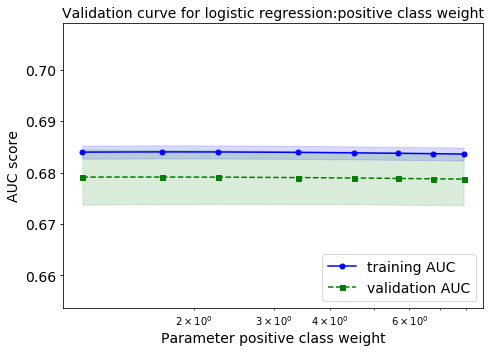

In [137]:
validation_curve_plt(train_mean_lr_w, 
                     train_std_lr_w, 
                     test_mean_lr_w, 
                     test_std_lr_w, 
                     [pos_class_w - 0.5 * pos_class_w,
                      pos_class_w - 0.25 * pos_class_w, 
                      pos_class_w, 
                      pos_class_w + 0.5 * pos_class_w, 
                      pos_class_w + 1 * pos_class_w, 
                      pos_class_w + 1.5 * pos_class_w,
                      pos_class_w + 2 * pos_class_w, 
                      pos_class_w + 2.5 * pos_class_w], 
                     'positive class weight', 
                     'logistic regression')

# Hyperparameter tuning using grid search (logistic regression)

In [138]:
C_range = [0.01, 0.1, 1, 10, 100]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

param_grid = [{'C': C_range, 'solver': solvers}]

gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs.best_score_))
print('Best parameters: ' + str(gs.best_params_))

Best AUC score on training data: 0.679120884545
Best parameters: {'C': 10, 'solver': 'saga'}


In [139]:
best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, 
                     y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score on test data: 0.677


# Stratified K-fold cross-validation (logistic regression).

In [43]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_clf.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_clf.predict_proba(X_train.values[test_fold])[:,1])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score: %.3f' 
          %(k+1, np.bincount(y_train[train_fold]), score))
    
print('\n CV AUC score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [13084  3716], Train AUC score: 0.680
Fold: 2, Class dist.: [13084  3716], Train AUC score: 0.689
Fold: 3, Class dist.: [13084  3716], Train AUC score: 0.679
Fold: 4, Class dist.: [13084  3716], Train AUC score: 0.675
Fold: 5, Class dist.: [13084  3716], Train AUC score: 0.670

 CV AUC score: 0.679 +/- 0.006


# Learning curve (logistic regression)

In [44]:
train_sizes_lr_lc, train_mean_lr_lc, train_std_lr_lc, test_mean_lr_lc, test_std_lr_lc = \
    learning_curve_output(X_train.values, 
                          y_train, 
                          best_clf)

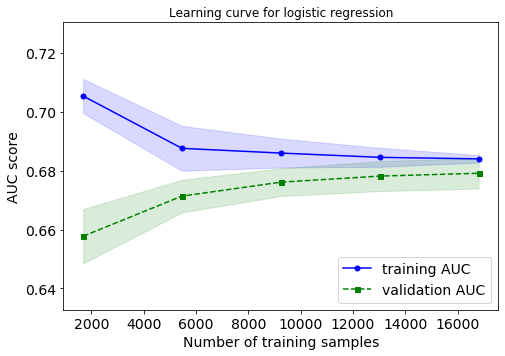

In [45]:
learning_curve_plt(train_sizes_lr_lc, 
                   train_mean_lr_lc, 
                   train_std_lr_lc, 
                   test_mean_lr_lc, 
                   test_std_lr_lc,
                  'logistic regression')

# Confusion matrix (logistic regression)

In [46]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[3866 3143]
 [ 593 1398]]


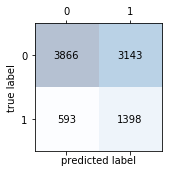

In [47]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

**We want to have 1 as a positive class in the confusion matric in the top left corner, therefore we need to swap labels in the confusion matrix.**

**1 - default**
**0 - no default**

In [48]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = [1,0])
print(confmat)

[[1398  593]
 [3143 3866]]


# Classification report for test data.

In [49]:
print('AUC score for the test data:', 
      roc_auc_score(y_true = y_test, 
                    y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score for the test data: 0.676117360481


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, 
                            y_pred, 
                            target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.87      0.55      0.67      7009
    defaulted       0.31      0.70      0.43      1991

     accuracy                           0.58      9000
    macro avg       0.59      0.63      0.55      9000
 weighted avg       0.74      0.58      0.62      9000



# ROC and Precision - Recall curves (logistic regression).

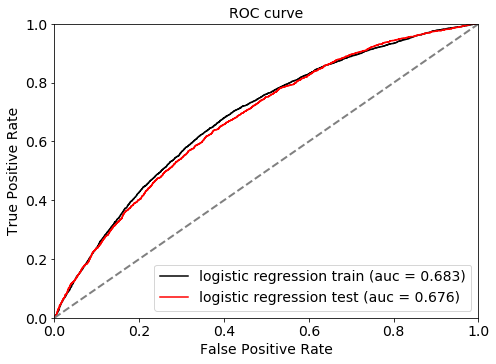

In [51]:
# assuming the label of the positive class is 1
y_pred_lr_train = best_clf.predict_proba(X_train)[:, 1]
y_pred_lr_test = best_clf.predict_proba(X_test)[:, 1]

ROC_plt(y_pred_lr_train, y_pred_lr_test, 'logistic regression')

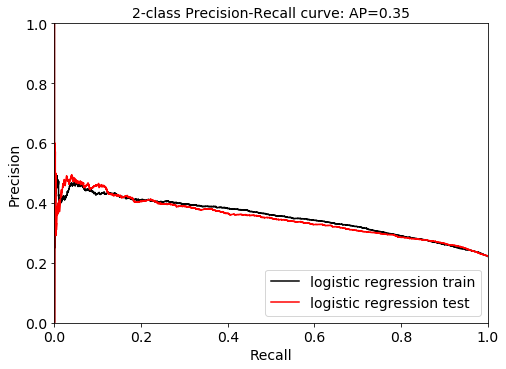

In [52]:
precision_recall_curve_plt(y_pred_lr_train, y_pred_lr_test, 'logistic regression')

# Random Forest classifier

In [53]:
rand_forest = RandomForestClassifier(class_weight='balanced', 
                                     n_jobs = -1, 
                                     random_state = 5)

# Fit the model on the trainng data.
rand_forest.fit(X_train, y_train)

print('Training accuracy (default random forest):', 
      accuracy_score(rand_forest.predict(X_train), y_train))
print('Test accuracy (default random forest):', 
      accuracy_score(rand_forest.predict(X_test), y_test))

print('AUC score for the training data (default random forest):', 
      roc_auc_score(y_true = y_train, 
                    y_score = rand_forest.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default random forest):', 
      roc_auc_score(y_true = y_test, 
                    y_score = rand_forest.predict_proba(X_test)[:,1]))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy (default random forest): 0.977
Test accuracy (default random forest): 0.780555555556
AUC score for the training data (default random forest): 0.999043747793
AUC score for the test data (default random forest): 0.678393296299


# Validation curve (random forest)

In [54]:
max_depth = [2, 4, 6, 10, 14, 18, 22]

train_mean_rf_dep, train_std_rf_dep, test_mean_rf_dep, test_std_rf_dep = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            rand_forest, 
                            max_depth, 
                            'max_depth')

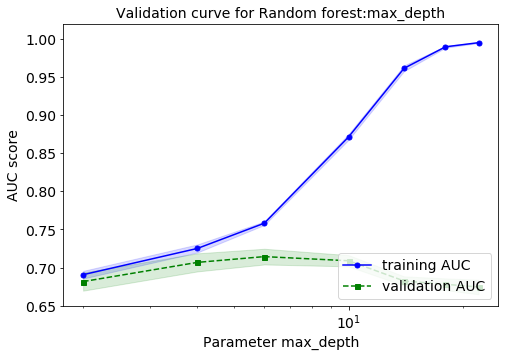

In [55]:
validation_curve_plt(train_mean_rf_dep, 
                     train_std_rf_dep, 
                     test_mean_rf_dep, 
                     test_std_rf_dep, 
                     max_depth, 
                     'max_depth', 
                     'Random forest')

In [56]:
n_estimators = [5, 10, 20, 50, 100]

rand_forest_upd = RandomForestClassifier(n_jobs = -1, 
                                         max_depth = 5, 
                                         class_weight='balanced', 
                                         random_state = 5)

train_mean_rf_est, train_std_rf_est, test_mean_rf_est, test_std_rf_est = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            rand_forest_upd, 
                            n_estimators, 
                            'n_estimators')

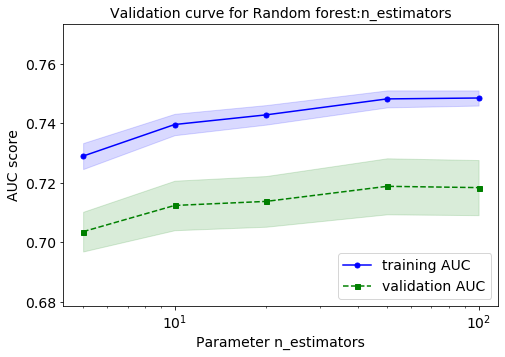

In [57]:
validation_curve_plt(train_mean_rf_est, 
                     train_std_rf_est, 
                     test_mean_rf_est, 
                     test_std_rf_est, 
                     n_estimators, 
                     'n_estimators', 
                     'Random forest')

# Hyperparameter tuning using grid search (random forest).

In [58]:
max_depth_optimized = [2, 3, 4, 5, 6]
n_estimators_optimized = [5, 10, 20, 50, 100]

param_grid = [{'n_estimators': n_estimators_optimized, 
               'max_depth': max_depth_optimized}]

gs_rf = GridSearchCV(estimator=rand_forest, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs_rf = gs_rf.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs_rf.best_score_))
print('Best parameters: ' + str(gs_rf.best_params_))

Best AUC score on training data: 0.723109729992
Best parameters: {'max_depth': 6, 'n_estimators': 100}


In [59]:
best_rand_forest = gs_rf.best_estimator_
best_rand_forest.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, 
                     y_score = best_rand_forest.predict_proba(X_test)[:,1]))

AUC score on test data: 0.724


# Stratified K-fold cross-validation (random forest).

In [60]:
scores_rf = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_rand_forest.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_rand_forest.predict_proba(X_train.values[test_fold])[:,1])
    scores_rf.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score: %.3f' 
          %(k+1, np.bincount(y_train[train_fold]), score))
    
print('\n CV AUC score: %.3f +/- %.3f' % (np.mean(scores_rf), np.std(scores_rf)))

Fold: 1, Class dist.: [13084  3716], Train AUC score: 0.714
Fold: 2, Class dist.: [13084  3716], Train AUC score: 0.729
Fold: 3, Class dist.: [13084  3716], Train AUC score: 0.728
Fold: 4, Class dist.: [13084  3716], Train AUC score: 0.721
Fold: 5, Class dist.: [13084  3716], Train AUC score: 0.724

 CV AUC score: 0.723 +/- 0.005


# Confusion matrix (optimized random forest)

In [61]:
y_pred_rf = best_rand_forest.predict(X_test)
confmat_rf = confusion_matrix(y_true=y_test, 
                              y_pred=y_pred_rf, 
                              labels = [1,0])
print(confmat_rf)

[[1294  697]
 [2335 4674]]


# Classification report for test data

In [62]:
print(classification_report(y_test, 
                            y_pred_rf, 
                            target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.87      0.67      0.76      7009
    defaulted       0.36      0.65      0.46      1991

     accuracy                           0.66      9000
    macro avg       0.61      0.66      0.61      9000
 weighted avg       0.76      0.66      0.69      9000



# ROC and Precision - Recall curves (random forest).

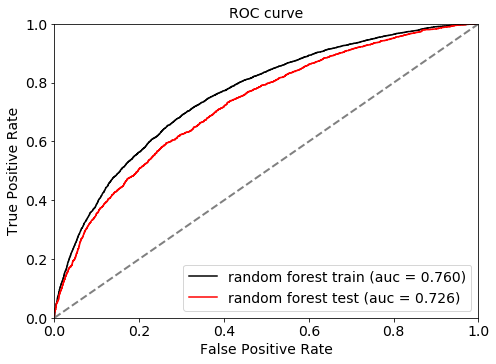

In [63]:
y_pred_rf_train = best_rand_forest.predict_proba(X_train)[:, 1]
y_pred_rf_test = best_rand_forest.predict_proba(X_test)[:, 1]

ROC_plt(y_pred_rf_train, y_pred_rf_test, 'random forest')

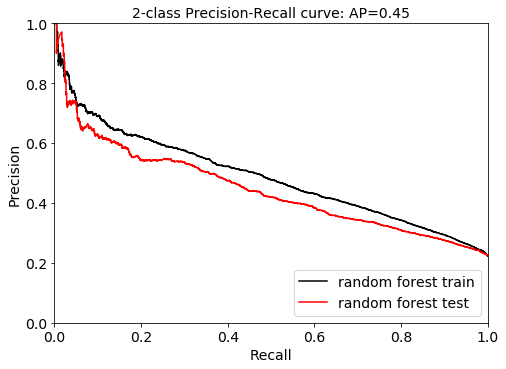

In [64]:
precision_recall_curve_plt(y_pred_rf_train, y_pred_rf_test, 'random forest')

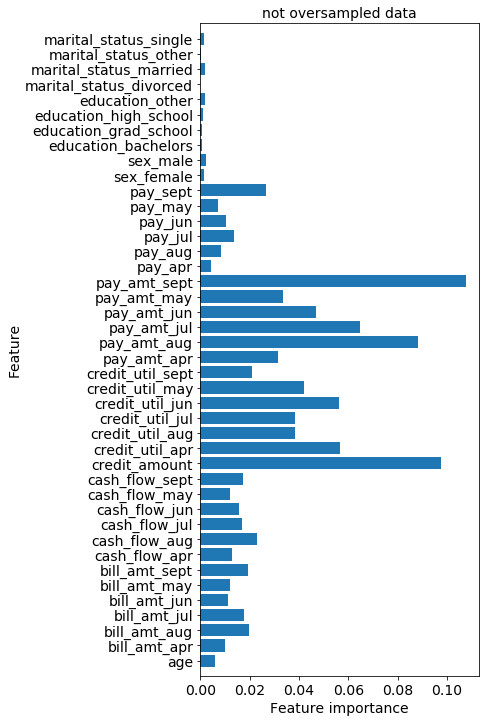

In [151]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    _ = plt.figure(figsize=(5,12))
    _ = plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    _ = plt.xticks(fontsize = 14)
    _ = plt.yticks(np.arange(n_features), X_train.columns, fontsize = 14)
    _ = plt.xlabel('Feature importance', fontsize = 14)
    _ = plt.ylabel('Feature', fontsize = 14)
    _ = plt.ylim(-1, n_features)
    _ = plt.title('not oversampled data', fontsize = 14)

    return plt

plot_feature_importances(best_rand_forest).show()

In [149]:
labels = X_train.columns
importances = best_rand_forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            labels[indices[f]], 
                            importances[indices[f]]))

 1) pay_amt_sept                   0.107682
 2) credit_amount                  0.097549
 3) pay_amt_aug                    0.088241
 4) pay_amt_jul                    0.064796
 5) credit_util_apr                0.056535
 6) credit_util_jun                0.056250
 7) pay_amt_jun                    0.047026
 8) credit_util_may                0.042077
 9) credit_util_aug                0.038567
10) credit_util_jul                0.038236
11) pay_amt_may                    0.033694
12) pay_amt_apr                    0.031332
13) pay_sept                       0.026751
14) cash_flow_aug                  0.022821
15) credit_util_sept               0.020807
16) bill_amt_aug                   0.019651
17) bill_amt_sept                  0.019531
18) bill_amt_jul                   0.017559
19) cash_flow_sept                 0.017378
20) cash_flow_jul                  0.016939
21) cash_flow_jun                  0.015740
22) pay_jul                        0.013725
23) cash_flow_apr               

# SVM

In [66]:
from sklearn.svm import SVC

svm = SVC(probability = True, class_weight = 'balanced')

# Fit the model on the trainng data.
svm.fit(X_train, y_train)

y_pred_svm_train = svm.predict(X_train)
y_pred_svm_test = svm.predict(X_test)

print('Training accuracy (default SVM):', 
      accuracy_score(y_true = y_train, 
                     y_pred = y_pred_svm_train))
print('Test accuracy (default SVM):', 
      accuracy_score(y_true = y_test, 
                     y_pred = y_pred_svm_test))

print('AUC score for the training data (default SVM):', 
      roc_auc_score(y_true = y_train, 
                    y_score = svm.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default SVM):', 
      roc_auc_score(y_true = y_test, 
                    y_score = svm.predict_proba(X_test)[:,1]))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training accuracy (default SVM): 0.669952380952
Test accuracy (default SVM): 0.633111111111
AUC score for the training data (default SVM): 0.76268948607
AUC score for the test data (default SVM): 0.709763524962


In [67]:
C_range = [0.5, 1, 5, 10, 50, 100]

train_mean_svm_C, train_std_svm_C, test_mean_svm_C, test_std_svm_C = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            SVC(gamma = 'scale', 
                                probability = True, 
                                class_weight = 'balanced'), 
                            C_range, 
                            'C')

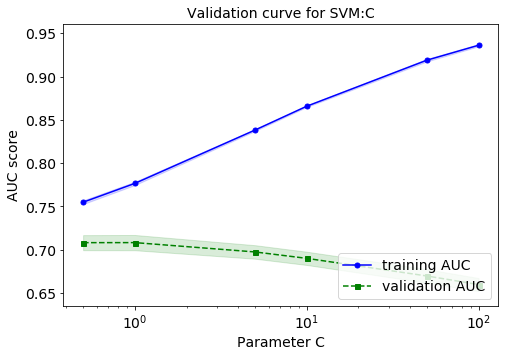

In [68]:
validation_curve_plt(train_mean_svm_C, 
                     train_std_svm_C, 
                     test_mean_svm_C, 
                     test_std_svm_C, 
                     C_range, 
                     'C', 
                     'SVM')

In [69]:
gamma_range = [0.01, 0.033, 0.05, 0.25]

train_mean_svm_gamma, train_std_svm_gamma, test_mean_svm_gamma, test_std_svm_gamma = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            svm, 
                            gamma_range, 
                            'gamma')

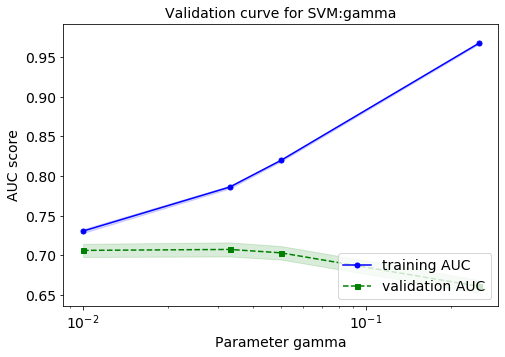

In [70]:
validation_curve_plt(train_mean_svm_gamma, 
                     train_std_svm_gamma, 
                     test_mean_svm_gamma, 
                     test_std_svm_gamma, 
                     gamma_range, 
                     'gamma', 
                     'SVM')

# Hyperparameter tuning using grid search (SVM).

In [71]:
C_range_optimized = [0.1, 0.5, 1]
gamma_range_optimized = [0.01, 0.02, 0.033]

param_grid = [{'C': C_range_optimized, 
               'gamma': gamma_range_optimized}]

gs_svm = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs_svm = gs_svm.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs_svm.best_score_))
print('Best parameters: ' + str(gs_svm.best_params_))

Best AUC score on training data: 0.708935687233
Best parameters: {'C': 1, 'gamma': 0.02}


In [72]:
best_svm = gs_svm.best_estimator_
best_svm.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, 
                     y_score = best_svm.predict_proba(X_test)[:,1]))

AUC score on test data: 0.709


# Stratified K-fold cross-validation (SVM).

In [73]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores_svm = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_svm.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_svm.predict_proba(X_train.values[test_fold])[:,1])
    scores_svm.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score (optimized SVM): %.3f' 
          %(k+1, np.bincount(y_train[train_fold]), score))

print('\n CV train AUC score (optimized SVM): %.3f +/- %.3f' 
      %(np.mean(scores_svm), np.std(scores_svm)))

Fold: 1, Class dist.: [13084  3716], Train AUC score (optimized SVM): 0.707
Fold: 2, Class dist.: [13084  3716], Train AUC score (optimized SVM): 0.717
Fold: 3, Class dist.: [13084  3716], Train AUC score (optimized SVM): 0.708
Fold: 4, Class dist.: [13084  3716], Train AUC score (optimized SVM): 0.710
Fold: 5, Class dist.: [13084  3716], Train AUC score (optimized SVM): 0.701

 CV train AUC score (optimized SVM): 0.708 +/- 0.005


# Confusion matrix (optimized SVM)

In [74]:
y_pred_best_svm = best_svm.predict(X_test)
confmat_svm = confusion_matrix(y_true=y_test, 
                               y_pred=y_pred_best_svm, 
                               labels = [1,0])
print(confmat_svm)

[[1371  620]
 [2718 4291]]


# Classification report (optimized SVM).

In [75]:
print('AUC score on test data:', 
      roc_auc_score(y_true = y_test, 
                    y_score = best_svm.predict_proba(X_test)[:,1]))

AUC score on test data: 0.707286584752


In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, 
                            y_pred_best_svm, 
                            target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.87      0.61      0.72      7009
    defaulted       0.34      0.69      0.45      1991

     accuracy                           0.63      9000
    macro avg       0.60      0.65      0.59      9000
 weighted avg       0.75      0.63      0.66      9000



# ROC and Precision - Recall curves (SVM).

In [77]:
y_pred_svm_train = best_svm.predict_proba(X_train)[:, 1]
y_pred_svm_test = best_svm.predict_proba(X_test)[:, 1]

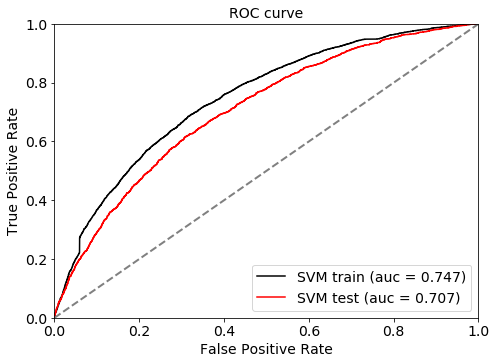

In [78]:
ROC_plt(y_pred_svm_train, y_pred_svm_test, 'SVM')

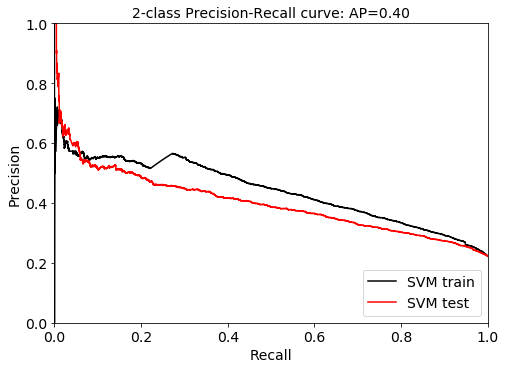

In [79]:
precision_recall_curve_plt(y_pred_svm_train, y_pred_svm_test, 'SVM')

# Voting classifier based on optimized logistic regression, random forest and SVM.

In [80]:
clf1 = best_clf
clf2 = best_rand_forest
clf3 = best_svm

ensemble = VotingClassifier(estimators=[('logred', clf1), ('rf', clf2), ('svm', clf3)], 
                            voting='soft')

# Fit the model on the trainng data.
ensemble.fit(X_train, y_train)

y_pred_ensemble_train = ensemble.predict(X_train)
y_pred_ensemble_test = ensemble.predict(X_test)

print('Training accuracy (ensemble):', 
      accuracy_score(y_true = y_train, 
                     y_pred = y_pred_ensemble_train))
print('Test accuracy (ensemble):', 
      accuracy_score(y_true = y_test, 
                     y_pred = y_pred_ensemble_test))

y_proba_ensemble_train = ensemble.predict_proba(X_train)[:, 1]
y_proba_ensemble_test = ensemble.predict_proba(X_test)[:, 1]

print('AUC score for the training data (ensemble):', 
      roc_auc_score(y_true = y_train, 
                    y_score = y_proba_ensemble_train))
print('AUC score for the test data (ensemble):', 
      roc_auc_score(y_true = y_test, 
                    y_score = y_proba_ensemble_test))

Training accuracy (ensemble): 0.759952380952
Test accuracy (ensemble): 0.739111111111
AUC score for the training data (ensemble): 0.744080665824
AUC score for the test data (ensemble): 0.714626218898


# Classification report (ensemble).

In [81]:
print(classification_report(y_test, y_pred_ensemble_test, target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.84      0.82      0.83      7009
    defaulted       0.42      0.45      0.43      1991

     accuracy                           0.74      9000
    macro avg       0.63      0.63      0.63      9000
 weighted avg       0.75      0.74      0.74      9000



# ROC and Precision - Recall curves (SVM).

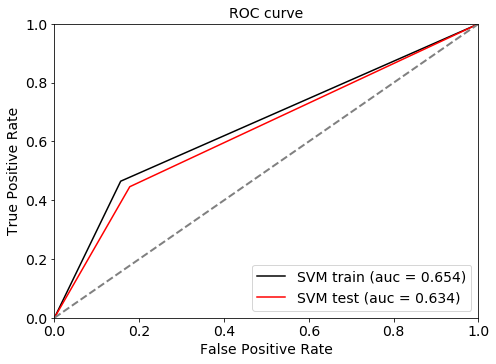

In [82]:
ROC_plt(y_pred_ensemble_train, y_pred_ensemble_test, 'SVM')

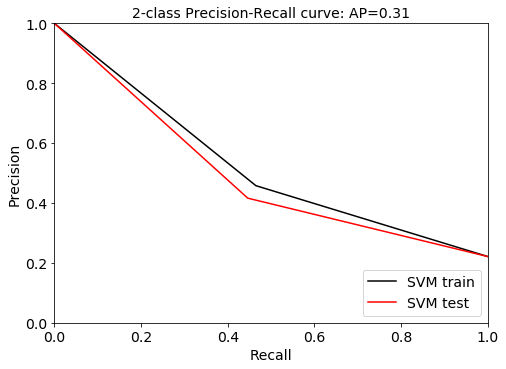

In [83]:
precision_recall_curve_plt(y_pred_ensemble_train, y_pred_ensemble_test, 'SVM')